<a href="https://colab.research.google.com/github/pra1608/quality-Prediction-in-mining/blob/main/LSTM_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [101]:
df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/cleaned.pkl')



In [102]:
df = df.set_index(['datetime'])

In [103]:
df

,date,year,month,day,hour,minute,second,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-30 00:00:00,2017-03-30 00:00:00,2017,3,30,0,0,0,59.54,9.56,1908.12,533.542,401.045,9.60323,1.72484,199.558,195.234,201.326,295.096,306.400,250.002,250.767,855.130039,821.072299,878.547321,459.554,592.059,551.010,522.392,66.36,1.69
2017-03-30 00:00:20,2017-03-30 00:00:00,2017,3,30,0,0,20,59.54,9.56,1894.65,533.922,400.325,9.60346,1.72505,199.561,194.898,201.855,295.096,306.400,250.000,250.757,855.129135,821.090690,878.661714,441.190,592.457,559.622,512.828,66.36,1.69
2017-03-30 00:00:40,2017-03-30 00:00:00,2017,3,30,0,0,40,59.54,9.56,1895.93,533.001,398.791,9.60369,1.72526,199.937,196.684,201.051,295.096,306.400,249.668,252.629,855.128230,821.109080,878.776107,453.158,590.323,548.417,501.807,66.36,1.69
2017-03-30 00:01:00,2017-03-30 00:00:00,2017,3,30,0,1,0,59.54,9.56,1876.59,534.324,396.910,9.60392,1.72547,199.819,196.919,199.288,295.096,306.400,250.138,250.395,855.127326,821.127471,878.890500,462.899,584.949,558.436,503.901,66.36,1.69
2017-03-30 00:01:20,2017-03-30 00:00:00,2017,3,30,0,1,20,59.54,9.56,1859.19,534.741,395.766,9.60415,1.72568,199.796,196.837,198.554,295.096,306.400,250.456,249.246,855.126421,821.145861,879.004893,476.801,581.155,560.810,507.434,66.36,1.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 23:58:20,2017-09-09 23:00:00,2017,9,9,23,58,20,49.75,23.20,2710.94,441.052,386.570,9.62129,1.65365,302.344,298.786,299.163,299.920,299.623,346.794,313.695,392.160000,430.702000,872.008000,418.725,497.548,446.357,416.892,64.27,1.71
2017-09-09 23:58:40,2017-09-09 23:00:00,2017,9,9,23,58,40,49.75,23.20,2692.01,473.436,384.939,9.62063,1.65352,303.013,301.879,299.487,299.710,300.465,330.023,236.700,401.505000,404.616000,864.409000,418.377,506.398,372.995,426.337,64.27,1.71
2017-09-09 23:59:00,2017-09-09 23:00:00,2017,9,9,23,59,0,49.75,23.20,2692.20,500.488,383.496,9.61874,1.65338,303.662,307.397,299.487,299.927,299.707,329.590,225.879,408.899000,399.316000,867.598000,419.531,503.414,336.035,433.130,64.27,1.71


##Data Preprocessing
Here we are picking 708480 data points for training. Observation is recorded every ~20 sec, that means 3 times per minute. 

We are tracking data from past 60 timestamps (60/3=20 minute). This data will be used to predict the temperature after 3 timestamps (3/3=1 minute).

Since every feature has values with varying ranges, we do normalization to confine feature values to a range of [0, 1] before training a neural network. We do this by subtracting the mean and dividing by the standard deviation of each feature.

80 % of the data will be used to train the model, i.e. 566784 rows. split_fraction can be changed to alter this percentage.


In [104]:
split_fraction = 0.8
train_split = int(split_fraction * int(df.shape[0]))
step = 3

past = 60
future = 3
learning_rate = 0.001
batch_size = 256
epochs = 10

In [105]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [106]:
df.columns

Index(['date', 'year', 'month', 'day', 'hour', 'minute', 'second',
       '% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level',
       '% Iron Concentrate', '% Silica Concentrate'],
      dtype='object')

In [107]:
df.columns[8:-2].tolist()

['% Silica Feed',
 'Starch Flow',
 'Amina Flow',
 'Ore Pulp Flow',
 'Ore Pulp pH',
 'Ore Pulp Density',
 'Flotation Column 01 Air Flow',
 'Flotation Column 02 Air Flow',
 'Flotation Column 03 Air Flow',
 'Flotation Column 04 Air Flow',
 'Flotation Column 05 Air Flow',
 'Flotation Column 06 Air Flow',
 'Flotation Column 07 Air Flow',
 'Flotation Column 01 Level',
 'Flotation Column 02 Level',
 'Flotation Column 03 Level',
 'Flotation Column 04 Level',
 'Flotation Column 05 Level',
 'Flotation Column 06 Level',
 'Flotation Column 07 Level']

In [110]:
selected_features = df.columns[8:].tolist()
features = df[selected_features]
features.head()



,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
datetime,,,,,,,,,,,,,,,,,,,,,,
2017-03-30 00:00:00,9.56,1908.12,533.542,401.045,9.60323,1.72484,199.558,195.234,201.326,295.096,306.4,250.002,250.767,855.130039,821.072299,878.547321,459.554,592.059,551.010,522.392,66.36,1.69
2017-03-30 00:00:20,9.56,1894.65,533.922,400.325,9.60346,1.72505,199.561,194.898,201.855,295.096,306.4,250.000,250.757,855.129135,821.090690,878.661714,441.190,592.457,559.622,512.828,66.36,1.69
2017-03-30 00:00:40,9.56,1895.93,533.001,398.791,9.60369,1.72526,199.937,196.684,201.051,295.096,306.4,249.668,252.629,855.128230,821.109080,878.776107,453.158,590.323,548.417,501.807,66.36,1.69
2017-03-30 00:01:00,9.56,1876.59,534.324,396.910,9.60392,1.72547,199.819,196.919,199.288,295.096,306.4,250.138,250.395,855.127326,821.127471,878.890500,462.899,584.949,558.436,503.901,66.36,1.69
2017-03-30 00:01:20,9.56,1859.19,534.741,395.766,9.60415,1.72568,199.796,196.837,198.554,295.096,306.4,250.456,249.246,855.126421,821.145861,879.004893,476.801,581.155,560.810,507.434,66.36,1.69


In [93]:
features

,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
datetime,,,,,,,,,,,,,,,,,,,,,,
2017-03-30 00:00:00,9.56,1908.12,533.542,401.045,9.60323,1.72484,199.558,195.234,201.326,295.096,306.400,250.002,250.767,855.130039,821.072299,878.547321,459.554,592.059,551.010,522.392,66.36,1.69
2017-03-30 00:00:20,9.56,1894.65,533.922,400.325,9.60346,1.72505,199.561,194.898,201.855,295.096,306.400,250.000,250.757,855.129135,821.090690,878.661714,441.190,592.457,559.622,512.828,66.36,1.69
2017-03-30 00:00:40,9.56,1895.93,533.001,398.791,9.60369,1.72526,199.937,196.684,201.051,295.096,306.400,249.668,252.629,855.128230,821.109080,878.776107,453.158,590.323,548.417,501.807,66.36,1.69
2017-03-30 00:01:00,9.56,1876.59,534.324,396.910,9.60392,1.72547,199.819,196.919,199.288,295.096,306.400,250.138,250.395,855.127326,821.127471,878.890500,462.899,584.949,558.436,503.901,66.36,1.69
2017-03-30 00:01:20,9.56,1859.19,534.741,395.766,9.60415,1.72568,199.796,196.837,198.554,295.096,306.400,250.456,249.246,855.126421,821.145861,879.004893,476.801,581.155,560.810,507.434,66.36,1.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 23:58:20,23.20,2710.94,441.052,386.570,9.62129,1.65365,302.344,298.786,299.163,299.920,299.623,346.794,313.695,392.160000,430.702000,872.008000,418.725,497.548,446.357,416.892,64.27,1.71
2017-09-09 23:58:40,23.20,2692.01,473.436,384.939,9.62063,1.65352,303.013,301.879,299.487,299.710,300.465,330.023,236.700,401.505000,404.616000,864.409000,418.377,506.398,372.995,426.337,64.27,1.71
2017-09-09 23:59:00,23.20,2692.20,500.488,383.496,9.61874,1.65338,303.662,307.397,299.487,299.927,299.707,329.590,225.879,408.899000,399.316000,867.598000,419.531,503.414,336.035,433.130,64.27,1.71


In [111]:
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,-0.668994,-0.719638,0.476354,0.208143,-0.637316,0.655866,-2.559247,-2.581396,-2.617558,-1.831182,1.890194,-1.471007,-1.481944,2.430046,2.169791,2.225197,0.452123,2.058016,1.451274,1.232376,1.154868,-0.569049
1,-0.668994,-0.730553,0.480567,0.104501,-0.636655,0.658792,-2.559148,-2.592395,-2.599675,-1.831182,1.890194,-1.471083,-1.482328,2.430039,2.169927,2.225934,0.240640,2.062929,1.551543,1.115754,1.154868,-0.569049
2,-0.668994,-0.729515,0.470357,-0.116312,-0.635993,0.661717,-2.546805,-2.533930,-2.626855,-1.831182,1.890194,-1.483596,-1.410411,2.430033,2.170062,2.226671,0.378465,2.036589,1.421083,0.981366,1.154868,-0.569049
3,-0.668994,-0.745186,0.485023,-0.387076,-0.635332,0.664643,-2.550679,-2.526237,-2.686456,-1.831182,1.890194,-1.465881,-1.496235,2.430026,2.170198,2.227409,0.490644,1.970257,1.537734,1.006900,1.154868,-0.569049
4,-0.668994,-0.759284,0.489646,-0.551750,-0.634671,0.667569,-2.551434,-2.528921,-2.711270,-1.831182,1.890194,-1.453895,-1.540376,2.430020,2.170334,2.228146,0.650742,1.923427,1.565374,1.049981,1.154868,-0.569049


In [113]:
X1 = features[features.columns.tolist()[0:20]]
Y1 = features[features.columns.tolist()[21]]


In [112]:
Y1

0        -0.569049
1        -0.569049
2        -0.569049
3        -0.569049
4        -0.569049
            ...   
708475   -0.551080
708476   -0.551080
708477   -0.551080
708478   -0.551080
708479   -0.551080
Name: 21, Length: 708480, dtype: float64

In [114]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
pd.pandas.set_option('display.max_columns', None)
feature_sel_model = SelectFromModel(Lasso(alpha=0.005, random_state=0)) # remember to set the seed, the random state in this function
feature_sel_model.fit(X1, Y1)

SelectFromModel(estimator=Lasso(alpha=0.005, copy_X=True, fit_intercept=True,
                                max_iter=1000, normalize=False, positive=False,
                                precompute=False, random_state=0,
                                selection='cyclic', tol=0.0001,
                                warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [115]:
selected_feat = X1.columns[(feature_sel_model.get_support())]


In [122]:
checklist = selected_feat.tolist()

In [117]:
features = features.loc[:,[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 16, 17, 19,21]]

In [119]:
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [120]:
train_data

,0,1,2,3,4,5,6,8,9,10,11,12,15,16,17,19,21
0,-0.668994,-0.719638,0.476354,0.208143,-0.637316,0.655866,-2.559247,-2.617558,-1.831182,1.890194,-1.471007,-1.481944,2.225197,0.452123,2.058016,1.232376,-0.569049
1,-0.668994,-0.730553,0.480567,0.104501,-0.636655,0.658792,-2.559148,-2.599675,-1.831182,1.890194,-1.471083,-1.482328,2.225934,0.240640,2.062929,1.115754,-0.569049
2,-0.668994,-0.729515,0.470357,-0.116312,-0.635993,0.661717,-2.546805,-2.626855,-1.831182,1.890194,-1.483596,-1.410411,2.226671,0.378465,2.036589,0.981366,-0.569049
3,-0.668994,-0.745186,0.485023,-0.387076,-0.635332,0.664643,-2.550679,-2.686456,-1.831182,1.890194,-1.465881,-1.496235,2.227409,0.490644,1.970257,1.006900,-0.569049
4,-0.668994,-0.759284,0.489646,-0.551750,-0.634671,0.667569,-2.551434,-2.711270,-1.831182,1.890194,-1.453895,-1.540376,2.228146,0.650742,1.923427,1.049981,-0.569049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566779,1.686074,0.164686,1.708951,2.144509,-0.580163,0.983559,0.752712,0.784029,2.168990,-1.027497,-1.467728,-1.546061,-0.274411,0.446100,1.011985,1.461523,1.542397
566780,1.686074,0.167295,1.725801,2.658254,-0.587609,0.990525,0.755961,0.781291,2.168974,-1.027417,-1.460944,-1.527199,-0.290956,0.182426,0.699679,1.258666,1.542397
566781,1.686074,0.178930,1.732242,1.893179,-0.595055,0.997630,0.741550,0.705091,2.168959,-1.027337,-1.456081,-1.412947,-0.294901,0.203293,0.412208,1.026422,1.542397
566782,1.686074,0.180000,1.672834,1.718860,-0.602472,1.004736,0.744143,0.647619,2.168943,-1.027256,-1.457551,-1.491817,-0.300598,0.505339,0.163914,0.754012,1.542397


#Training dataset


In [125]:
start = past + future
end = start + train_split

x_train = train_data[checklist].values
y_train = features.iloc[start:end][[21]]

sequence_length = int(past / step)

In [126]:
x_train.shape

(566784, 16)

In [127]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

#Validation dataset


In [128]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][checklist].values
y_val = features.iloc[label_start:][[21]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 20, 16)
Target shape: (256, 1)


In [129]:
x_val

array([[ 1.68607356,  0.18431032,  1.61405862, ...,  1.01594174,
         0.54683449,  0.3160825 ],
       [ 1.68607356,  0.19002264,  1.57585764, ...,  1.22671025,
         0.73642497,  0.25578396],
       [ 1.68607356,  0.19095444,  1.59233084, ...,  1.36529557,
         0.9341002 ,  0.4746268 ],
       ...,
       [ 1.37056921,  0.67145394, -0.11413113, ..., -0.22870038,
         2.2509764 , -0.50570913],
       [ 1.37056921,  0.61948396, -0.27550422, ..., -0.18875086,
         1.33557284, -0.35084737],
       [ 1.37056921, -1.1246623 , -0.59145493, ..., -0.21949898,
        -0.00358271, -0.16337928]])

#Training


In [130]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(64)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 20, 16)]          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 20,801
Trainable params: 20,801
Non-trainable params: 0
_________________________________________________________________


In [131]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
2214/2214 [==============================] - ETA: 0s - loss: 0.8627
Epoch 00001: val_loss improved from inf to 1.00519, saving model to model_checkpoint.h5
2214/2214 [==============================] - 180s 81ms/step - loss: 0.8627 - val_loss: 1.0052
Epoch 2/10
2214/2214 [==============================] - ETA: 0s - loss: 0.8294
Epoch 00002: val_loss did not improve from 1.00519
2214/2214 [==============================] - 179s 81ms/step - loss: 0.8294 - val_loss: 1.0095
Epoch 3/10
2214/2214 [==============================] - ETA: 0s - loss: 0.8068
Epoch 00003: val_loss improved from 1.00519 to 0.99351, saving model to model_checkpoint.h5
2214/2214 [==============================] - 179s 81ms/step - loss: 0.8068 - val_loss: 0.9935
Epoch 4/10
2214/2214 [==============================] - ETA: 0s - loss: 0.7901
Epoch 00004: val_loss did not improve from 0.99351
2214/2214 [==============================] - 179s 81ms/step - loss: 0.7901 - val_loss: 0.9991
Epoch 5/10
2214/2214 [====

We can visualize the loss with the function below. After one point, the loss stops decreasing.

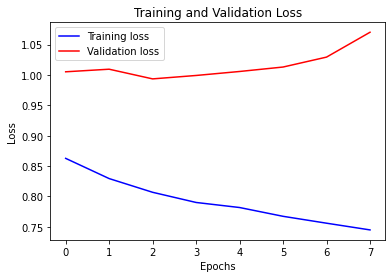

In [132]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

#Prediction
The trained model above is now able to make predictions for 5 sets of values from validation set.

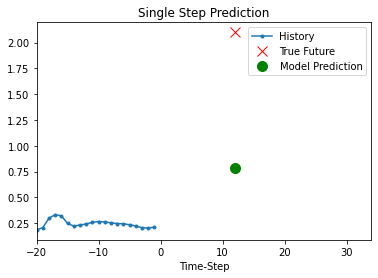

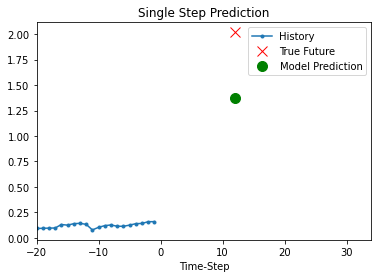

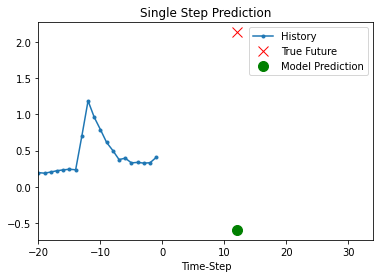

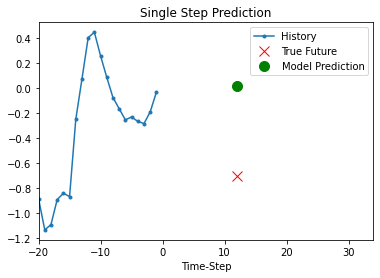

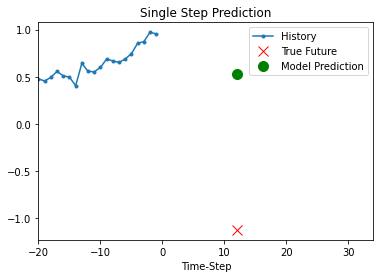

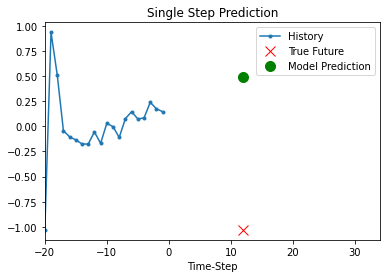

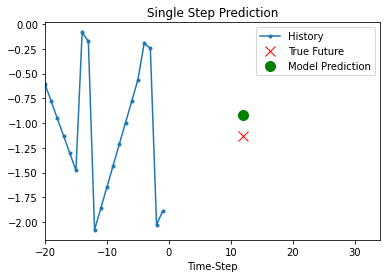

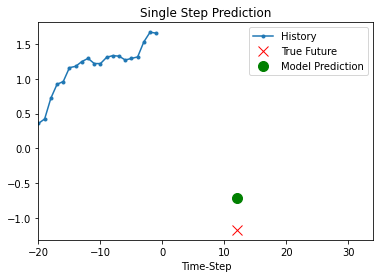

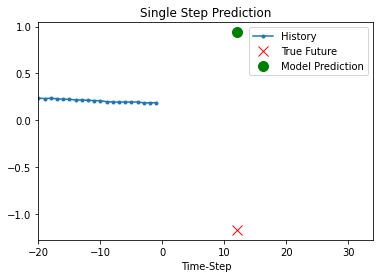

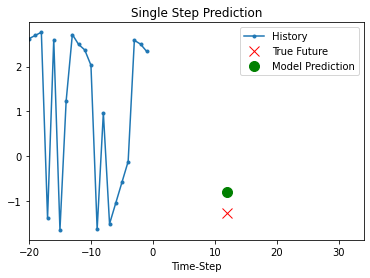

In [133]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(10):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )